# Data Preparation

## 1. Import Library and Data

In [1]:
## Komputasi
import pandas as pd
import numpy as np

## Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

## Multicollinearity
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif 

## Scaling data
from sklearn.preprocessing import StandardScaler

## Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

## Model Evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

    ### R2 Score
from sklearn.metrics import r2_score

import warnings
warnings.simplefilter(action='ignore')

In [2]:
taxi = pd.read_parquet('yellow_tripdata_2021-09.parquet', engine='fastparquet')

## 2. Data Inspection

In [3]:
taxi.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2021-09-01 06:04:34,2021-09-01 06:15:28,2.0,4.90,1.0,N,87,229,1,16.0,0.5,0.5,2.00,0.00,0.3,21.80,2.5,0.0
1,2,2021-09-01 06:26:31,2021-09-01 06:32:39,1.0,1.13,1.0,N,162,229,1,6.0,0.5,0.5,1.96,0.00,0.3,11.76,2.5,0.0
2,2,2021-09-01 06:36:15,2021-09-01 06:40:30,2.0,1.37,1.0,N,141,262,1,6.0,0.5,0.5,1.96,0.00,0.3,11.76,2.5,0.0
3,1,2021-09-01 00:00:15,2021-09-01 00:18:34,2.0,6.50,1.0,N,90,260,2,21.0,3.0,0.5,0.00,6.55,0.3,31.35,2.5,0.0
4,2,2021-09-01 00:44:54,2021-09-01 00:56:33,1.0,2.32,1.0,N,75,238,2,10.5,0.5,0.5,0.00,0.00,0.3,11.80,0.0,0.0


In [4]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2963793 entries, 0 to 2963792
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

In [5]:
## Cek unique values pada Dataframe
for x in taxi.columns : 
    print (f'===== {x} =====')
    print (f'{taxi[x].unique()}')
    print()

===== VendorID =====
[2 1 6 5]

===== tpep_pickup_datetime =====
['2021-09-01T06:04:34.000000000' '2021-09-01T06:26:31.000000000'
 '2021-09-01T06:36:15.000000000' ... '2021-09-30T23:46:03.000000000'
 '2021-09-30T23:16:35.000000000' '2021-09-30T23:25:29.000000000']

===== tpep_dropoff_datetime =====
['2021-09-01T06:15:28.000000000' '2021-09-01T06:32:39.000000000'
 '2021-09-01T06:40:30.000000000' ... '2021-09-30T23:49:22.000000000'
 '2021-09-30T23:55:44.000000000' '2021-10-01T00:19:02.000000000']

===== passenger_count =====
[ 2.  1.  5.  0.  3.  4.  6.  7.  8.  9. nan]

===== trip_distance =====
[4.9000000e+00 1.1300000e+00 1.3700000e+00 ... 5.7778690e+04 3.1970780e+04
 1.0403818e+05]

===== RatecodeID =====
[ 1.  2.  5.  4.  3. 99.  6. nan]

===== store_and_fwd_flag =====
['N' 'Y' None]

===== PULocationID =====
[ 87 162 141  90  75 239 137  45  93 181 234 233 132 148  79 163 140 229
 263 249 138 243 107 170 211 100 231 161  41  43  48 142 116 144 151  50
 186 244 238 261 113 158  74 2

[ 0.    1.25 -1.25   nan]



- Remove negative values at column `extra`, `mta_tax`, `tolls_amount`, `improvement_surcharge`, `congestion_surcharge`, `airport_fee`
- Remove anomaly values at column `RatecodeID`, it is 99
- Remove anomaly values at column `payment_type`, it is 0
- Make new colum named 'travel_time' yang represents the travel time
- and new colum named 'fare_permil' yang represents cost of travel per mile
- Transform data type column `store_and_fwd_flag` to boolean

### 2.1 Create new column

In [6]:
## Column 'travel_time'

taxi['travel_time'] = taxi['tpep_dropoff_datetime']-taxi['tpep_pickup_datetime']
taxi['travel_time'] = (taxi['travel_time'] / np.timedelta64(1, 'm')).round(2)

In [7]:
## Column 'fare_permil'

taxi['fare_permil'] = (taxi['fare_amount'] / taxi['trip_distance']).round(2)

In [8]:
taxi.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,travel_time,fare_permil
0,2,2021-09-01 06:04:34,2021-09-01 06:15:28,2.0,4.90,1.0,N,87,229,1,...,0.5,0.5,2.00,0.00,0.3,21.80,2.5,0.0,10.90,3.27
1,2,2021-09-01 06:26:31,2021-09-01 06:32:39,1.0,1.13,1.0,N,162,229,1,...,0.5,0.5,1.96,0.00,0.3,11.76,2.5,0.0,6.13,5.31
2,2,2021-09-01 06:36:15,2021-09-01 06:40:30,2.0,1.37,1.0,N,141,262,1,...,0.5,0.5,1.96,0.00,0.3,11.76,2.5,0.0,4.25,4.38
3,1,2021-09-01 00:00:15,2021-09-01 00:18:34,2.0,6.50,1.0,N,90,260,2,...,3.0,0.5,0.00,6.55,0.3,31.35,2.5,0.0,18.32,3.23
4,2,2021-09-01 00:44:54,2021-09-01 00:56:33,1.0,2.32,1.0,N,75,238,2,...,0.5,0.5,0.00,0.00,0.3,11.80,0.0,0.0,11.65,4.53


## 3. Data Cleaning

### 3.1 Check Duplicated Rows

In [9]:
taxi.duplicated().sum()

0

Conclusion : There is no duplicated rows in dataset `taxi` 

### 3.2 Remove anomaly values

In [10]:
## Remove negative values

taxi = taxi[taxi['trip_distance'] > 0]
taxi = taxi[taxi['extra'] >= 0]  
taxi = taxi[taxi['mta_tax'] >= 0]
taxi = taxi[taxi['tolls_amount'] >= 0]
taxi = taxi[taxi['improvement_surcharge'] >= 0]
taxi = taxi[taxi['congestion_surcharge'] >= 0]
taxi = taxi[taxi['airport_fee'] >= 0]

In [11]:
## Remove anomaly values

taxi = taxi[taxi.RatecodeID != 99]
taxi = taxi[taxi.payment_type != 0]

### 3.3 Handling Missing Values

In [12]:
# Cek missing values
(taxi.isna().sum() * 100 / len(taxi))

VendorID                 0.0
tpep_pickup_datetime     0.0
tpep_dropoff_datetime    0.0
passenger_count          0.0
trip_distance            0.0
RatecodeID               0.0
store_and_fwd_flag       0.0
PULocationID             0.0
DOLocationID             0.0
payment_type             0.0
fare_amount              0.0
extra                    0.0
mta_tax                  0.0
tip_amount               0.0
tolls_amount             0.0
improvement_surcharge    0.0
total_amount             0.0
congestion_surcharge     0.0
airport_fee              0.0
travel_time              0.0
fare_permil              0.0
dtype: float64

Conclusion : There is no missing values in dataset `taxi`

In [13]:
taxi.shape

(2756170, 21)

### 3.4 Feature Transform

In [14]:
## Encod colum `store_and_fwd_flag`
def fwd_class(x):
    if x == 'N':
        return 0
    else:
        return 1
    
taxi['store_and_fwd_flag'] = np.vectorize(fwd_class)(taxi['store_and_fwd_flag'])

# Exploratory Data Analysis

## 4. Descriptive Statistic

In [15]:
numericals = taxi.select_dtypes(include=["int","float"]).columns
categoricals = taxi.select_dtypes("object").columns

print("Numericals Column {}".format(numericals.to_list()))
print("Categoricals Column {}".format(categoricals.to_list()))

Numericals Column ['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'airport_fee', 'travel_time', 'fare_permil']
Categoricals Column []


In [16]:
# Numericals Statistical Summary
taxi[numericals].describe()

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,travel_time,fare_permil
count,2.756170e+06,2.756170e+06,2.756170e+06,2.756170e+06,2.756170e+06,2.756170e+06,2.756170e+06,2.756170e+06,2.756170e+06,2.756170e+06,2.756170e+06,2.756170e+06,2.756170e+06,2.756170e+06,2.756170e+06,2.756170e+06,2.756170e+06,2.756170e+06,2.756170e+06
mean,1.696047e+00,1.430740e+00,3.288945e+00,1.044412e+00,1.221405e-02,1.644759e+02,1.625929e+02,1.227698e+00,1.389236e+01,1.076031e+00,4.975562e-01,2.490900e+00,4.065351e-01,2.999842e-01,2.034031e+01,2.329043e+00,7.890478e-02,1.726762e+01,7.666920e+00
std,4.599625e-01,1.028961e+00,4.479070e+00,2.900675e-01,1.098402e-01,6.562807e+01,7.044312e+01,4.356287e-01,4.930282e+02,1.248941e+00,3.502257e-02,2.854221e+00,1.727150e+00,2.175910e-03,4.931073e+02,6.310046e-01,3.039820e-01,5.968785e+01,2.156760e+02
min,1.000000e+00,0.000000e+00,1.000000e-02,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,1.000000e+00,1.130000e+00,1.000000e+00,0.000000e+00,1.320000e+02,1.130000e+02,1.000000e+00,7.000000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,1.180000e+01,2.500000e+00,0.000000e+00,7.220000e+00,4.130000e+00
50%,2.000000e+00,1.000000e+00,1.890000e+00,1.000000e+00,0.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,1.000000e+01,5.000000e-01,5.000000e-01,2.060000e+00,0.000000e+00,3.000000e-01,1.536000e+01,2.500000e+00,0.000000e+00,1.168000e+01,5.120000e+00
75%,2.000000e+00,1.000000e+00,3.360000e+00,1.000000e+00,0.000000e+00,2.340000e+02,2.340000e+02,1.000000e+00,1.500000e+01,2.500000e+00,5.000000e-01,3.160000e+00,0.000000e+00,3.000000e-01,2.136000e+01,2.500000e+00,0.000000e+00,1.858000e+01,6.360000e+00
max,2.000000e+00,9.000000e+00,7.915400e+02,6.000000e+00,1.000000e+00,2.650000e+02,2.650000e+02,4.000000e+00,8.182834e+05,9.000000e+00,3.300000e+00,3.333300e+02,9.600000e+01,3.000000e-01,8.182867e+05,2.750000e+00,1.250000e+00,8.510870e+03,3.273134e+05


Conlcusion : 

- Average of trip distance is 3,2 mils
- Average of cost fare per mil is 7,6 dollar
- Average of travel time is 17,2 minutes

## 5. Univariate Analysis

### 5.1 Handling Outliers

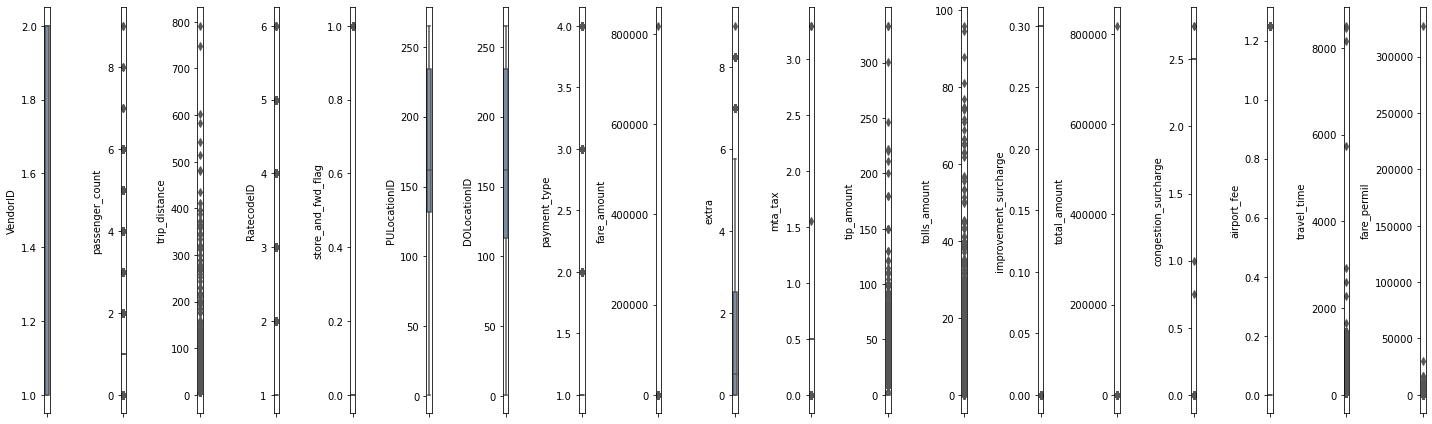

In [17]:
plt.figure(figsize=(20,6))
features = numericals
for i in range(0, len(features)):
    plt.subplot(1, len(features), i+1)
    sns.boxplot(y=taxi[features[i]], color='#778da9')
    plt.tight_layout()

Conclusion :
- There is some column that have outliers, including `trip_distance`,`fare_amount`,`tolls_amount`,`total_amount`, `minutes`, and `fare_permil`

### a. trip_distance

In [18]:
taxi['trip_distance'].sort_values(ascending=[False]).head()

1640562    791.54
2380491    747.30
28415      601.30
2375151    582.70
436045     543.00
Name: trip_distance, dtype: float64

Conlusion :  There no extreme gap between the data, no need remove outliers

### b. fare_amount

In [19]:
for i in np.arange(0.0, 1.0, 0.1):
    var =taxi["fare_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 52.0
99.1 percentile value is 53.0
99.2 percentile value is 55.0
99.3 percentile value is 57.5
99.4 percentile value is 60.0
99.5 percentile value is 63.5
99.6 percentile value is 66.0
99.7 percentile value is 70.0
99.8 percentile value is 77.0
99.9 percentile value is 98.5
100 percentile value is  818283.44


In [20]:
taxi['fare_amount'].sort_values(ascending=[False]).head()

394006     818283.44
2265336       695.00
670797        554.00
802611        529.50
1754811       520.00
Name: fare_amount, dtype: float64

In [21]:
taxi_mod = taxi[(taxi.fare_amount>0) & (taxi.fare_amount<700)]

Conlusion :  Remove outliers with values more than 700

### c. tolls_amount

In [22]:
taxi_mod['tolls_amount'].sort_values(ascending=[False]).head()

204        96.00
1082305    94.66
119143     88.00
1226280    81.00
1738145    77.00
Name: tolls_amount, dtype: float64

Conlusion :  There no extreme gap between the data, no need remove outliers

### d. total_amount

In [23]:
taxi['total_amount'].sort_values(ascending=[False]).head()

394006     818286.74
2265336       695.30
119143        590.90
670797        567.90
2402457       564.51
Name: total_amount, dtype: float64

In [24]:
taxi_mod = taxi_mod[(taxi_mod.total_amount<700)]

Conlusion :  Remove outliers with values more than 700

### e. minutes

In [25]:
taxi['travel_time'].sort_values(ascending=[False]).head()

80157      8510.87
80156      8470.35
78435      8148.75
1776439    5739.67
76245      2921.10
Name: travel_time, dtype: float64

Conlusion :  There no extreme gap between the data, no need remove outliers

### f. fare_permil

In [26]:
taxi['fare_permil'].sort_values(ascending=[False]).head()

394006     327313.38
2486995     30000.00
476970      16500.00
337245      16500.00
200690      15000.00
Name: fare_permil, dtype: float64

In [27]:
taxi_mod = taxi_mod[(taxi_mod.fare_permil<17000)]

Conlusion :  Remove outliers with values more than 17000

## 6. Multivariate Analysis

### 6.1 Correlation heatmap

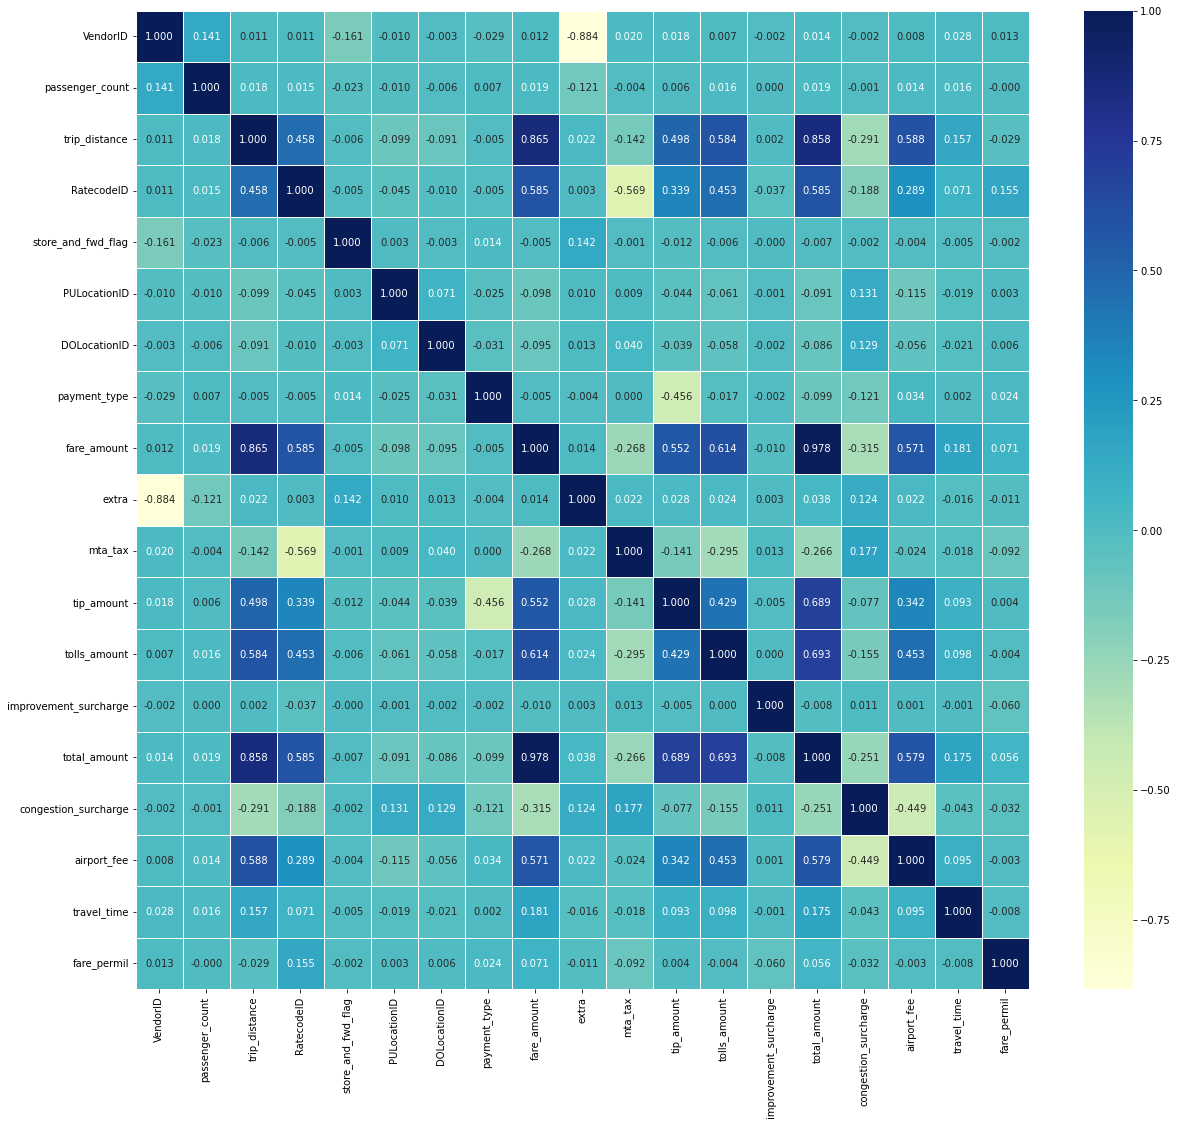

In [28]:
fig, ax = plt.subplots(figsize = (20, 18))
sns.heatmap(taxi_mod.corr(),cbar=True,annot=True,linewidths=0.5,ax=ax,fmt='.3f',cmap="YlGnBu")
plt.show()

Conclusion :

Feature yang memiliki korelasi tinggi (>2) pada target variabel (`total_amount`) adalah :
- `fare_amount`
- `trip_distance`
- `tolls_amount`
- `tip_amount`
- `RatecodeID`
- `airport_fee`
- `mta_tax`
- `congestion_surcharge`

# Dive Question

In [29]:
df = taxi_mod.copy()

## 7. Deep Dive Question

### A. Apa yang menyebabkan layanan yellow taxi hanya berpusat di boroughs tertentu sehingga menyebabkan ketidakseimbangan permintaan dan penawaran pada boroughs lain?

### A1. Boroughs dengan jumlah transaksi taxi terbanyak

In [30]:
df['PULocationID'].value_counts().head(10)

237    138657
236    123842
132    108283
161     95178
186     93247
142     89594
162     87222
170     86454
48      82297
239     80284
Name: PULocationID, dtype: int64

- Manhattan = 237, 236, 161, 186, 142, 162, 170, 48, 239, 141, 234, 79, 163, 230, 68, 107, 263,238
- Queens = 132, 138

Conclusion :

Dari analisa tersebut dapat dinyatakan bahwa daerah dengan transaksi tertinggi adalah Manhattan, maka akan dipisahkan dataset antara transaksi daerah Manhattan dan Non-Manhattan

In [31]:
list_manhattan = [103,104,105,12,88,81,261,13,209,231,45,232,148,144,211,125,4,79,114,113,249,158,224,107,234,90,68,246,186,164,137,170,100,50,48,230,161,162,233,229,163,143,142,43,237,141,140,202,262,263,236,75,239,238,151,24,166,41,74,194,152,42,116,244,120,243,127,128,153]

manhattan = df.loc[df['PULocationID'].isin(list_manhattan) & df['DOLocationID'].isin(list_manhattan)]
not_manhattan = df[~df.index.isin(manhattan.index)]

In [32]:
manhattan.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,travel_time,fare_permil
count,2.327658e+06,2.327658e+06,2.327658e+06,2.327658e+06,2.327658e+06,2.327658e+06,2.327658e+06,2.327658e+06,2.327658e+06,2.327658e+06,2.327658e+06,2.327658e+06,2.327658e+06,2.327658e+06,2.327658e+06,2.327658e+06,2.327658e+06,2.327658e+06,2.327658e+06
mean,1.694961e+00,1.426047e+00,2.044649e+00,1.003450e+00,1.232956e-02,1.674336e+02,1.664879e+02,1.219951e+00,1.015237e+01,1.076081e+00,4.993294e-01,2.004868e+00,5.924629e-03,2.999960e-01,1.573544e+01,2.441129e+00,1.551989e-04,1.418417e+01,7.334288e+00
std,4.604241e-01,1.029098e+00,1.875353e+00,1.060116e-01,1.103519e-01,6.656190e+01,6.851077e+01,4.286434e-01,5.284383e+00,1.211585e+00,1.851442e-02,1.755455e+00,2.340205e-01,1.094812e-03,6.263715e+00,3.790907e-01,1.392748e-02,5.583754e+01,7.111001e+01
min,1.000000e+00,0.000000e+00,1.000000e-02,1.000000e+00,0.000000e+00,4.000000e+00,4.000000e+00,1.000000e+00,1.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.100000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,1.000000e+00,1.050000e+00,1.000000e+00,0.000000e+00,1.160000e+02,1.140000e+02,1.000000e+00,6.500000e+00,0.000000e+00,5.000000e-01,9.500000e-01,0.000000e+00,3.000000e-01,1.163000e+01,2.500000e+00,0.000000e+00,6.670000e+00,4.520000e+00
50%,2.000000e+00,1.000000e+00,1.650000e+00,1.000000e+00,0.000000e+00,1.630000e+02,1.630000e+02,1.000000e+00,9.000000e+00,5.000000e-01,5.000000e-01,2.000000e+00,0.000000e+00,3.000000e-01,1.430000e+01,2.500000e+00,0.000000e+00,1.042000e+01,5.400000e+00
75%,2.000000e+00,1.000000e+00,2.570000e+00,1.000000e+00,0.000000e+00,2.360000e+02,2.360000e+02,1.000000e+00,1.250000e+01,2.500000e+00,5.000000e-01,2.950000e+00,0.000000e+00,3.000000e-01,1.836000e+01,2.500000e+00,0.000000e+00,1.563000e+01,6.600000e+00
max,2.000000e+00,9.000000e+00,3.347000e+02,6.000000e+00,1.000000e+00,2.630000e+02,2.630000e+02,4.000000e+00,5.295000e+02,7.000000e+00,3.300000e+00,3.333300e+02,9.600000e+01,3.000000e-01,5.353000e+02,2.500000e+00,1.250000e+00,2.278130e+03,1.100000e+04


In [33]:
not_manhattan.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,travel_time,fare_permil
count,428049.000000,428049.000000,428049.000000,428049.000000,428049.000000,428049.000000,428049.000000,428049.000000,428049.000000,428049.000000,428049.000000,428049.000000,428049.000000,428049.000000,428049.000000,428049.000000,428049.000000,428049.000000,428049.000000
mean,1.702364,1.456417,10.052764,1.264883,0.011552,148.399587,141.404937,1.268324,32.332483,1.076755,0.488278,5.135165,2.583810,0.299973,43.486097,1.721288,0.507091,34.038464,8.649260
std,0.457219,1.027981,7.467894,0.643552,0.106860,57.700230,76.745083,0.466887,18.878571,1.435308,0.075823,5.229424,3.642447,0.002863,23.946477,1.157754,0.613778,75.176587,140.143876
min,1.000000,0.000000,0.010000,1.000000,0.000000,1.000000,1.000000,1.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.310000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,4.820000,1.000000,0.000000,132.000000,82.000000,1.000000,18.500000,0.000000,0.500000,0.000000,0.000000,0.300000,25.000000,0.000000,0.000000,17.870000,2.930000
50%,2.000000,1.000000,9.090000,1.000000,0.000000,138.000000,138.000000,1.000000,29.500000,0.500000,0.500000,4.390000,0.000000,0.300000,40.950000,2.500000,0.000000,27.220000,3.270000
75%,2.000000,2.000000,14.830000,1.000000,0.000000,164.000000,217.000000,2.000000,47.000000,1.750000,0.500000,8.400000,6.550000,0.300000,59.500000,2.500000,1.250000,39.470000,3.910000
max,2.000000,9.000000,791.540000,6.000000,1.000000,265.000000,265.000000,4.000000,695.000000,9.000000,3.300000,222.000000,94.660000,0.300000,695.300000,2.750000,1.250000,8510.870000,16500.000000


In [34]:
print('Total Transaction in Manhattan : ', manhattan.shape)
print('Total Transaction in Non-Manhattan : ', not_manhattan.shape)

Total Transaction in Manhattan :  (2327658, 21)
Total Transaction in Non-Manhattan :  (428049, 21)


In [35]:
man_percent = (2327915/(2327915+428254))*100
print('Persentase Transaction in Manhattan :', man_percent)

Persentase Transaction in Manhattan : 84.46198328186696


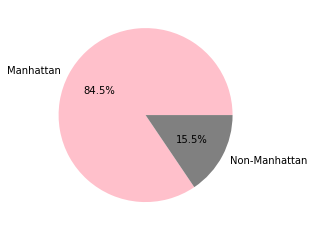

In [36]:
y = np.array([man_percent, 100-man_percent])
mylabels = ["Manhattan", "Non-Manhattan"]
mycolors = ["pink","grey"]

plt.pie(y, labels = mylabels, autopct='%1.1f%%', colors = mycolors)
plt.show() 

Conclusion : 

- Jumlah transaksi di Manhattan jauh lebih tinggi dibandingkan daerah Non-Manhattan 
- 84.5% transaksi taxi terjadi di daerah Manhattan

### A2. Apa penyebab taxi lebih sering beroperasi di Manhattan daripada daerah lain ?

### Trip Distance

In [37]:
def distance_man(x):
    if x < 1:
        return '0-1'
    elif x < 2:
        return '1-2'
    elif x < 3:
        return '2-3'
    elif x < 4:
        return '3-4'
    elif x < 5:
        return '4-5'
    else:
        return 'Above 5'
    
manhattan['trip_distance'] = np.vectorize(distance_man)(manhattan['trip_distance'])

<AxesSubplot:xlabel='count', ylabel='trip_distance'>

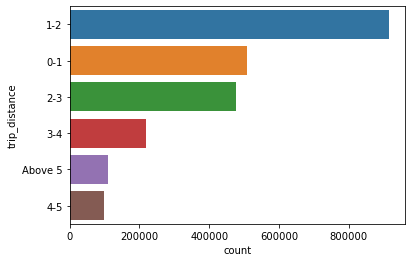

In [38]:
sns.countplot(y=manhattan['trip_distance'], order = manhattan['trip_distance'].value_counts().index)

In [39]:
def distance_nm(x):
    if x < 5:
        return '0-5'
    elif x < 10:
        return '5-10'
    elif x < 15:
        return '10-15'
    elif x < 20:
        return '15-20'
    else:
        return 'Above 20'
    
not_manhattan['trip_distance'] = np.vectorize(distance_nm)(not_manhattan['trip_distance'])

<AxesSubplot:xlabel='count', ylabel='trip_distance'>

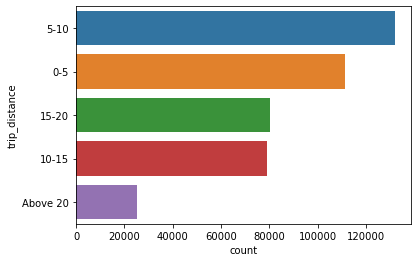

In [40]:
sns.countplot(y=not_manhattan['trip_distance'], order = not_manhattan['trip_distance'].value_counts().index)

#### Conclusion :

- Mayoritas jarak tempuh taxi di daerah Manhattan cukup rendah yaitu 1-2 mil, berbeda jauh dengan daerah Non-Manhattan dengan mayoritas jarak tempuh 5-10 mil

### fare_amount

In [41]:
def fare_man(x):
    if x < 5:
        return '0-5'
    elif x < 10:
        return '5-10'
    elif x < 15:
        return '10-15'
    elif x < 20:
        return '15-20'
    elif x < 25:
        return '20-25'
    else:
        return 'Above 25'
    
manhattan['fare_amount'] = np.vectorize(fare_man)(manhattan['fare_amount'])

<AxesSubplot:xlabel='count', ylabel='fare_amount'>

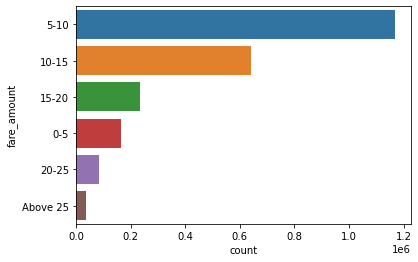

In [42]:
sns.countplot(y=manhattan['fare_amount'], order = manhattan['fare_amount'].value_counts().index)

In [43]:
def fare_nm(x):
    if x < 10:
        return '0-10'
    elif x < 20:
        return '10-20'
    elif x < 30:
        return '20-30'
    elif x < 40:
        return '30-40'
    elif x < 50:
        return '40-50'
    elif x < 60:
        return '50-60'
    else:
        return 'Above 60'
    
not_manhattan['fare_amount'] = np.vectorize(fare_nm)(not_manhattan['fare_amount'])

<AxesSubplot:xlabel='count', ylabel='fare_amount'>

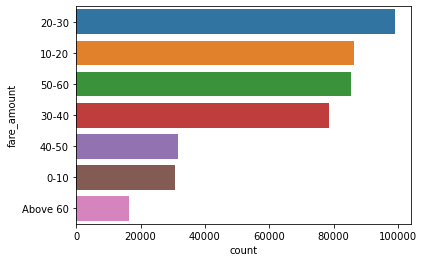

In [44]:
sns.countplot(y=not_manhattan['fare_amount'], order = not_manhattan['fare_amount'].value_counts().index)

Conclusion :

- Mayoritas tarif taxi di daerah Manhattan adalah 5-10 dollar, berbeda jauh dengan daerah Non-Manhattan dengan mayoritas tarif taxi 20-30 dollar

### fare_permil

In [45]:
def fare_man(x):
    if x < 2:
        return '0-2'
    elif x < 4:
        return '2-4'
    elif x < 6:
        return '4-6'
    elif x < 8:
        return '6-8'
    elif x < 10:
        return '8-10'
    else:
        return 'Above 10'
    
manhattan['fare_class'] = np.vectorize(fare_man)(manhattan['fare_permil'])

<AxesSubplot:xlabel='count', ylabel='fare_class'>

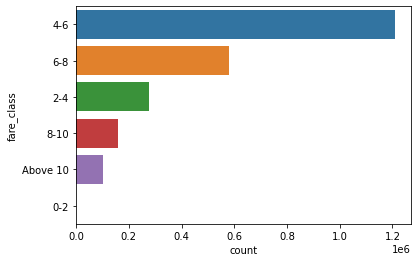

In [46]:
sns.countplot(y=manhattan['fare_class'], order = manhattan['fare_class'].value_counts().index)

In [47]:
def fare_nm(x):
    if x < 2:
        return '0-2'
    elif x < 4:
        return '2-4'
    elif x < 6:
        return '4-6'
    elif x < 8:
        return '6-8'
    elif x < 10:
        return '8-10'
    else:
        return 'Above 10'
    
not_manhattan['fare_class'] = np.vectorize(fare_nm)(not_manhattan['fare_permil'])

<AxesSubplot:xlabel='count', ylabel='fare_class'>

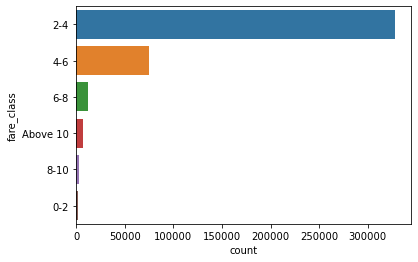

In [48]:
sns.countplot(y=not_manhattan['fare_class'], order = not_manhattan['fare_class'].value_counts().index)

Conclusion :

- Tarif taxi per mil di Manhatan (5 dollar) lebih tinggi dibandingkan dengan Non-Manhattan (3 Dollar)

### Tip Amount

In [49]:
def tip_man(x):
    if x <= 0:
        return 'No'
    else:
        return 'Yes'
    
manhattan['tip'] = np.vectorize(tip_man)(manhattan['tip_amount'])

<AxesSubplot:xlabel='tip', ylabel='count'>

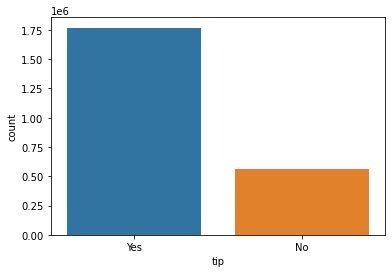

In [50]:
sns.countplot(x=manhattan['tip'])

In [51]:
a = 100 - (manhattan['tip_amount'].value_counts()[0] / manhattan['tip_amount'].shape[0])*100
print ('Persentase dapat tip di Manhattan :', a)

Persentase dapat tip di Manhattan : 76.00949108503053


In [52]:
def tip_nm(x):
    if x <= 0:
        return 'No'
    else:
        return 'Yes'
    
not_manhattan['tip'] = np.vectorize(tip_nm)(not_manhattan['tip_amount'])

<AxesSubplot:xlabel='tip', ylabel='count'>

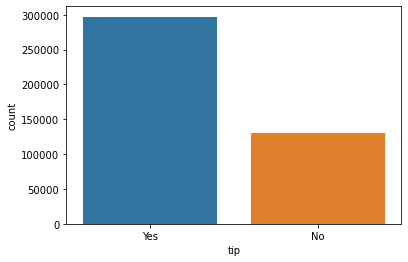

In [53]:
sns.countplot(x=not_manhattan['tip'])

In [54]:
a = 100 - (not_manhattan['tip_amount'].value_counts()[0] / not_manhattan['tip_amount'].shape[0])*100
print ('Persentase dapat tip di Non-Manhattan :', a)

Persentase dapat tip di Non-Manhattan : 69.43247151611146


Conclusion :

- Persentase dalam mendapatkan tip dari pelanggan di Daerah Manhattan lebih tinggi (selisih 6,5%)

### Travel time

In [55]:
def minutes_man(x):
    if x < 5:
        return '0-5'
    elif x < 10:
        return '5-10'
    elif x < 15:
        return '10-15'
    elif x < 20:
        return '15-20'
    elif x < 25:
        return '20-25'
    else:
        return 'Above 25'
    
manhattan['minute_class'] = np.vectorize(minutes_man)(manhattan['travel_time'])

<AxesSubplot:xlabel='count', ylabel='minute_class'>

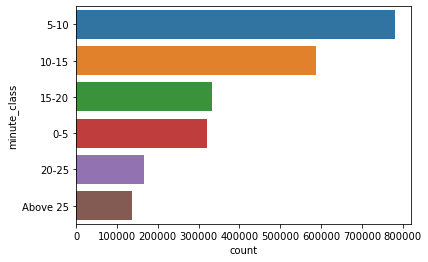

In [56]:
sns.countplot(y=manhattan['minute_class'], order = manhattan['minute_class'].value_counts().index)

In [57]:
def minutes_nm(x):
    if x < 10:
        return '0-10'
    elif x < 20:
        return '10-20'
    elif x < 30:
        return '20-30'
    elif x < 40:
        return '30-40'
    elif x < 50:
        return '40-50'
    elif x < 60:
        return '50-60'
    else:
        return 'Above 60'
    
not_manhattan['minute_class'] = np.vectorize(minutes_nm)(not_manhattan['travel_time'])

<AxesSubplot:xlabel='count', ylabel='minute_class'>

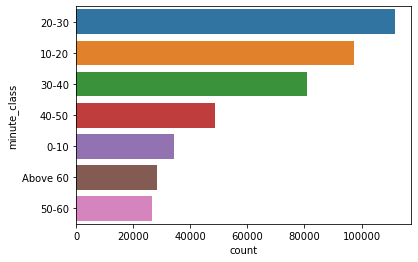

In [58]:
sns.countplot(y=not_manhattan['minute_class'], order = not_manhattan['minute_class'].value_counts().index)

Conclusion :
- Mayoritas lama perjalanan di Manhattan hanya 5-10 menit, sedangkan di Non-Manhattan 20-30 menit 

### Answer :

Dari analisa yang telah saya lakukan, saya dapat memberikan beberapa alasan mengapa layana Yellow Taxi hanya berpusat pada boroughs tertentu. Dalam analisa saya layanan Taxi hanya berpusat pada daerah Manhattan, dengan persentase transaksi sebesar 84.5% dari total transaksi, alasanya :
- Mayoritas Jarak tempuh tiap transaksi di daerah Manhattan (1-2 mil) jauh lebih dekat jika dibandingkan dengan daerah Non-Manhattan (5-10 mil)
- Walaupun mayoritas tarif taxi di daerah Manhattan lebih kecil daripada daerah Non-Manhattan, namun jika dihitung dengan tarif per mil nya, daerah Manhattan (5 dollar / mil) memiliki tarif per mil yang lebih tinggi daripada daerah Non-Manhattan (3 dollar / mil)
- Mayoritas waktu tempuh tiap transaksi di Manhattan (5-10 menit) lebih singkat daripada daerah Non-Manhattan (20-30 menit), maka dalam sehari driver yang beroperasi di Manhattan akan lebih banyak mendapatkan orderan
- Daerah Manhattan memiliki persentase kemungkinan mendapatakan tip yang lebih tinggi, dengan selisih 6,5%. Walaupun selisihnya kecil, namun karena jarak perjalannya relatif dekat dengan waktu yang lebih singkat, maka driver akan lebih sering melakukan transaksi dan mendapatkan tips lebih banyak

### B. TLC ingin agar layanan yellow taxi mereka tersebar secara merata di seluruh kota New York sehingga dapat menjawab demand yang ada. Apa yang harus TLC lakukan secara short-term (6 bulan) untuk mengatasi tantangan ini?

Bagaimana cara agar driver mau beroperasi di luar daerah Manhattan ?

## airport_fee

<AxesSubplot:xlabel='airport_fee', ylabel='count'>

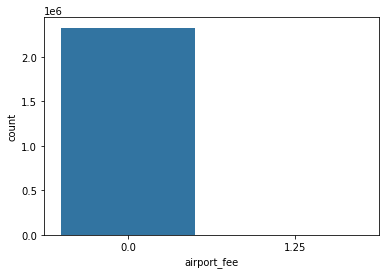

In [59]:
sns.countplot(x=manhattan['airport_fee'], order = manhattan['airport_fee'].value_counts().index)

In [60]:
a = 100 - (manhattan['airport_fee'].value_counts()[0] / manhattan['airport_fee'].shape[0])*100
print ('Persentase perjalanan bandara di Non-Manhattan :', a)

Persentase perjalanan bandara di Non-Manhattan : 0.012415913334351103


<AxesSubplot:xlabel='airport_fee', ylabel='count'>

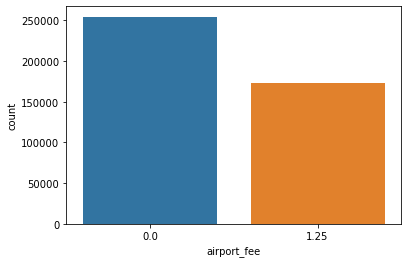

In [61]:
sns.countplot(x=not_manhattan['airport_fee'], order = not_manhattan['airport_fee'].value_counts().index)

In [62]:
a = 100 - (not_manhattan['airport_fee'].value_counts()[0] / not_manhattan['airport_fee'].shape[0])*100
print ('Persentase perjalanan bandara di Non-Manhattan :', a)

Persentase perjalanan bandara di Non-Manhattan : 40.56731822758609


Conclusion :

- Transaksi penjemputan di Bandara lebih sering terjadi pada daerah Non-Manhattan, dengan selisih kemungkinan 40% lebih banyak 

## congestion_surcharge

<AxesSubplot:xlabel='congestion_surcharge', ylabel='count'>

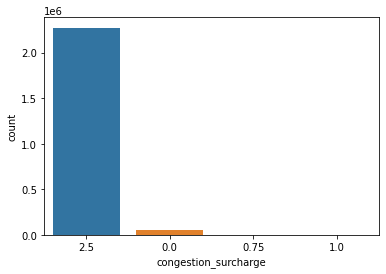

In [63]:
sns.countplot(x=manhattan['congestion_surcharge'], order = manhattan['congestion_surcharge'].value_counts().index)

In [64]:
a = (manhattan['congestion_surcharge'].value_counts()[2.5] / manhattan['tip_amount'].shape[0])*100
print ('Persentase Kemungkinan Macet di Manhattan :', a)

Persentase Kemungkinan Macet di Manhattan : 97.64514374534403


<AxesSubplot:xlabel='congestion_surcharge', ylabel='count'>

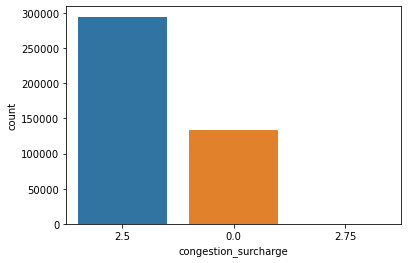

In [65]:
sns.countplot(x=not_manhattan['congestion_surcharge'], order = not_manhattan['congestion_surcharge'].value_counts().index)

In [66]:
a = (not_manhattan['congestion_surcharge'].value_counts()[2.5] / not_manhattan['tip_amount'].shape[0])*100
print ('Persentase Kemungkinan Macet di Non-Manhattan :', a)

Persentase Kemungkinan Macet di Non-Manhattan : 68.85099603082824


Conclusion :

- Persentase kemungkinan macet di daerah Manhattan sangat tinggi (97%), jika dibandingkan dengan daerah Non-Manhattan (68%)

### Answer :

Solusi jangka pendek yang dapat TLC lakukan untuk meratakan transaksi taxi di New York antara lain :
- Mayoritas jarak perjalanan di daerah Non-Manhattan jauh, maka dapat membuat pull di beberapa titik, agar driver dapat istirahat
- Daerah Manhattan sering macet (97%), maka dapat memotong sebagian kecil biaya tambahan kemacetan pada driver Manhattan untuk dialokasikan menjadi bonus pada driver Non-Manhattan
- Perjalanan Bandara lebih sering dilakukan di daerah Non-Manhattan (46%), maka TLC dapat memberikan bonus pada driver yang melakukan perjalanan bandara (dari biaya potongan macet Manhattan
- Karena di daerah Manhattan sering macet, maka pihak TLC dapat memberikan sosialisasi mengenai besar kemungkinan driver akan terkena macet jika beroperasi di Manhattan


# Data Preprocessing

## 8. Spliting Data Train dan Test

In [67]:
# Splitting data train and testing (75%,25%)

X = taxi_mod.drop('total_amount',axis=1).copy()
y = taxi_mod['total_amount'].copy()

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25, random_state=42)

In [68]:
# Insert target variabel pada X_train untuk memudahkan EDA
X_train['total_amount'] = y_train

## 9 . Feature Selection

Pilih feature yang berkorelasi tinggi dengan target variabel (source : 6. Multivariate Analysis)

In [69]:
X_train_top = X_train[['trip_distance','tolls_amount','tip_amount','RatecodeID','airport_fee','mta_tax','congestion_surcharge']]
X_train_top.head()

,trip_distance,tolls_amount,tip_amount,RatecodeID,airport_fee,mta_tax,congestion_surcharge
2098827,1.92,0.00,3.54,1.0,0.00,0.5,2.5
1153956,18.69,6.55,0.00,2.0,1.25,0.5,0.0
659660,10.12,6.55,8.77,1.0,0.00,0.5,2.5
848062,4.90,0.00,5.55,1.0,0.00,0.5,2.5
1220394,2.74,0.00,2.00,1.0,0.00,0.5,2.5


In [70]:
X_test_top = X_test.copy()
X_test_top = X_test_top[X_train_top.columns]
X_test_top.head()

,trip_distance,tolls_amount,tip_amount,RatecodeID,airport_fee,mta_tax,congestion_surcharge
2639205,1.60,0.00,2.75,1.0,0.0,0.5,2.5
2453145,10.35,6.55,0.00,1.0,0.0,0.5,2.5
2459033,1.00,0.00,2.55,1.0,0.0,0.5,2.5
2519586,8.34,0.00,5.00,1.0,0.0,0.5,2.5
814096,0.60,0.00,1.00,1.0,0.0,0.5,2.5


## 10. Multicollinearity Check

In [71]:
# Hitung VIF Score
X = add_constant(X_train_top)

vif = pd.DataFrame([vif(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns).reset_index()
vif.columns = ['feature','vif_score']
vif = vif.loc[vif.feature!='const']
vif

,feature,vif_score
1,trip_distance,2.249163
2,tolls_amount,1.793621
3,tip_amount,1.421345
4,RatecodeID,1.947575
5,airport_fee,1.913657
6,mta_tax,1.653529
7,congestion_surcharge,1.341592


Konklusi :

Tidak terdapat features yang memiliki VIF score tinggi (>4), maka dapat melanjutkan modeling

## 11. Feature Scaling

In [72]:
scaler = StandardScaler()

In [73]:
feature_scaling = ['trip_distance','tolls_amount','tip_amount','RatecodeID','mta_tax','congestion_surcharge']

In [74]:
## Scaling Train data
X_train_top[feature_scaling] = scaler.fit_transform(X_train_top[feature_scaling])

In [75]:
## Scaling Test data
X_test_top[feature_scaling] = scaler.fit_transform(X_test_top[feature_scaling])

# Modeling Data

## 12. Baseline Model - Normal Regression

### a. Training Model

In [76]:
# define the model
multi_reg = LinearRegression()

# train the model
X_train_taxi = X_train_top.to_numpy()
y_train_taxi = y_train.to_numpy()
y_train_taxi = y_train_taxi.reshape(len(y_train_taxi,))

multi_reg.fit(X_train_taxi, y_train_taxi)

LinearRegression()

In [77]:
# retrieve the coefficients

data = X_train_top
model = multi_reg

coef_df = pd.DataFrame({
    'feature':['intercept'] + data.columns.tolist(),
    'coefficient':[model.intercept_] + list(model.coef_)
})

coef_df

,feature,coefficient
0,intercept,19.810646
1,trip_distance,7.651256
2,tolls_amount,2.545681
3,tip_amount,4.273190
4,RatecodeID,2.229513
5,airport_fee,2.906499
6,mta_tax,-0.259346
7,congestion_surcharge,0.065350


### b. Model Diagnostic

In [78]:
## R2-Score

y_train_predict = multi_reg.predict(X_train_taxi)
print('R-squared for training data is {}'.format(r2_score(y_train_taxi, y_train_predict)))

R-squared for training data is 0.881286936962127


Konklusi :

88% dari total variabilitas `total_amount` berhasil dimodelkan menggunakan fitur yang digunakan. Maka, model Normal Linier Regresion optimal dalam memodelkan pola yang ada dalam dataset

### c. Model Evaluation

#### Train Data

In [79]:
print('RMSE for training data is {}'.format(np.sqrt(mean_squared_error(y_train_taxi, y_train_predict))))
print('MAE for training data is {}'.format(mean_absolute_error(y_train_taxi, y_train_predict)))
print('MAPE for training data is {}'.format(mean_absolute_percentage_error(y_train_taxi, y_train_predict)))

RMSE for training data is 5.145166016775075
MAE for training data is 2.5594627830847845
MAPE for training data is 0.1540672396441118


#### Test Data

In [80]:
## Prepare prediction result on test data
X_test_taxi = X_test_top.to_numpy()
y_test_predict = multi_reg.predict(X_test_taxi)

## Ground truth target
y_test_taxi = y_test.to_numpy()
y_test_taxi = y_test_taxi.reshape(len(y_test_taxi),)

In [81]:
print('RMSE for testing data is {}'.format(np.sqrt(mean_squared_error(y_test_taxi, y_test_predict))))
print('MAE for testing data is {}'.format(mean_absolute_error(y_test_taxi, y_test_predict)))
print('MAPE for testing data is {}'.format(mean_absolute_percentage_error(y_test_taxi, y_test_predict)))

RMSE for testing data is 5.243222910574917
MAE for testing data is 2.601084920373775
MAPE for testing data is 0.15615706469337623


Konklusi :

- RMSE = Standar deviasi dari prediksi error pada data test memiliki nilai sebesar 5,2. Maka, residualnya menyimpang sebesar 5,2 dari garis linier regresi
- MAPE = Pada data test, secara rata-rata prediksi rating yang dihasilkan menyimpang dari rating sesungguhnya sebesar ±15,6%
- Dilihat dari nilai MAPE pada data train dan test, keduanya memiliki nilai error yang tidak cukup tinggi (<30 %), maka dapat dinyatakn bahwa model normal regresion tidak mengalami underfitting maupun overfitting

## 12. Modified Model

### 12.1 Ridge

### a. Training Model

In [82]:
X = taxi_mod[X_train_top.columns]
y = taxi_mod['total_amount'].copy()

In [83]:
X[feature_scaling] = scaler.fit_transform(X[feature_scaling])

In [84]:
# split train test
# First splitting: pretrain and test
feature_taxi_pretrain, feature_taxi_test, target_taxi_pretrain, target_taxi_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Second splitting: train and validation
feature_taxi_train, feature_taxi_validation, target_taxi_train, target_taxi_validation = train_test_split(feature_taxi_pretrain, target_taxi_pretrain, test_size=0.20, random_state=42)

In [85]:
# train the model
X_taxi_train = feature_taxi_train.to_numpy()
y_taxi_train = target_taxi_train.to_numpy()
y_taxi_train = y_taxi_train.reshape(len(y_taxi_train),)

# define the model
# 4 models with 4 different alphas (lambda)
ridge_reg_pointzeroone = Ridge(alpha=0.01, random_state=42)
ridge_reg_pointone = Ridge(alpha=0.1, random_state=42)
ridge_reg_one = Ridge(alpha=1, random_state=42)
ridge_reg_ten = Ridge(alpha=10, random_state=42)

# fit the model (training)
ridge_reg_pointzeroone.fit(X_taxi_train, y_taxi_train)
ridge_reg_pointone.fit(X_taxi_train, y_taxi_train)
ridge_reg_one.fit(X_taxi_train, y_taxi_train)
ridge_reg_ten.fit(X_taxi_train, y_taxi_train)

Ridge(alpha=10, random_state=42)

In [86]:
X_taxi_validation = feature_taxi_validation.to_numpy()
y_taxi_validation = target_taxi_validation.to_numpy()
y_taxi_validation = y_taxi_validation.reshape(len(y_taxi_validation),)

alphas = [0.01, 0.1, 1., 10]
models = [ridge_reg_pointzeroone,
          ridge_reg_pointone,
          ridge_reg_one,
          ridge_reg_ten]

for model, alpha in zip(models, alphas):
    y_predict_validation = model.predict(X_taxi_validation)
    rmse = np.sqrt(mean_squared_error(y_taxi_validation,y_predict_validation))
    print(f'RMSE of Ridge regression model with alpha = {alpha} is {rmse}')
    

RMSE of Ridge regression model with alpha = 0.01 is 4.997552008699263
RMSE of Ridge regression model with alpha = 0.1 is 4.997552017701052
RMSE of Ridge regression model with alpha = 1.0 is 4.997552107724126
RMSE of Ridge regression model with alpha = 10 is 4.997553008473902


Conclusion :

Ridge dengan alpha = 0.01 mempunyai nilai RMSE paling kecil, maka alpha = 0.01 merupakan merupakan model terbaik untuk Ridge.

In [87]:
# Ridge dengan Alpha = 10
ridge_best = ridge_reg_pointzeroone

coef_df = pd.DataFrame({
    'feature':['intercept'] + feature_taxi_train.columns.tolist(),
    'coefficient':[ridge_best.intercept_] + list(ridge_best.coef_)
})

coef_df

,feature,coefficient
0,intercept,19.811365
1,trip_distance,7.544987
2,tolls_amount,2.587329
3,tip_amount,4.317179
4,RatecodeID,2.272017
5,airport_fee,3.055871
6,mta_tax,-0.254299
7,congestion_surcharge,0.050374


### b. Model Diagnostic

In [88]:
## R2-Score

y_predict_train = ridge_best.predict(X_taxi_train)
print('R-squared for training data is {}'.format(r2_score(y_taxi_train, y_predict_train)))

R-squared for training data is 0.8790240063336925


Konklusi :

87% dari total variabilitas `total_amount` berhasil dimodelkan menggunakan fitur yang digunakan. Maka, model Normal Linier Regresion optimal dalam memodelkan pola yang ada dalam dataset

### c. Model Evaluation

In [89]:
# prepare prediction result on train data
y_predict_train = ridge_best.predict(X_taxi_train)

# prepare prediction result on test data
X_taxi_test = feature_taxi_test.to_numpy()
y_predict_test = ridge_best.predict(X_taxi_test)

# ground truth target
y_taxi_test = target_taxi_test.to_numpy()
y_taxi_test = y_taxi_test.reshape(len(y_taxi_test),)

#### Train Data

In [90]:
print('RMSE for training data is {}'.format(np.sqrt(mean_squared_error(y_taxi_train, y_predict_train))))
print('MAE for training data is {}'.format(mean_absolute_error(y_taxi_train, y_predict_train)))
print('MAPE for training data is {}'.format(mean_absolute_percentage_error(y_taxi_train, y_predict_train)))

RMSE for training data is 5.197263925432571
MAE for training data is 2.5920383952544364
MAPE for training data is 0.15591828735495306


#### Test Data

In [91]:
print('RMSE for testing data is {}'.format(np.sqrt(mean_squared_error(y_taxi_test, y_predict_test))))
print('MAE for testing data is {}'.format(mean_absolute_error(y_taxi_test, y_predict_test)))
print('MAPE for testing data is {}'.format(mean_absolute_percentage_error(y_taxi_test, y_predict_test)))

RMSE for testing data is 5.21824958750778
MAE for testing data is 2.6006082946335702
MAPE for testing data is 0.15552692793038067


Konklusi :

- RMSE = Standar deviasi dari prediksi error pada data test memiliki nilai sebesar 5,2. Maka, residualnya menyimpang sebesar 5,2 dari garis linier regresi
- MAPE = Pada data test, secara rata-rata prediksi rating yang dihasilkan menyimpang dari rating sesungguhnya sebesar ±15,5%
- Dilihat dari nilai MAPE pada data train dan test, keduanya memiliki nilai error yang tidak cukup tinggi (<30 %), maka dapat dinyatakn bahwa model normal regresion tidak mengalami underfitting maupun overfitting

### 12.2 LASSO

### a. Training Model

In [92]:
# train the model
X_taxi_train = feature_taxi_train.to_numpy()
y_taxi_train = target_taxi_train.to_numpy()
y_taxi_train = y_taxi_train.reshape(len(y_taxi_train),)

# define the model
# 4 models with 4 different alphas (lambda)
lasso_reg_pointzeroone = Lasso(alpha=0.01, random_state=42)
lasso_reg_pointone = Lasso(alpha=0.1, random_state=42)
lasso_reg_one = Lasso(alpha=1, random_state=42)
lasso_reg_ten = Lasso(alpha=10, random_state=42)

# fit the model (training)
lasso_reg_pointzeroone.fit(X_taxi_train, y_taxi_train)
lasso_reg_pointone.fit(X_taxi_train, y_taxi_train)
lasso_reg_one.fit(X_taxi_train, y_taxi_train)
lasso_reg_ten.fit(X_taxi_train, y_taxi_train)

Lasso(alpha=10, random_state=42)

In [93]:
X_taxi_validation = feature_taxi_validation.to_numpy()
y_taxi_validation = target_taxi_validation.to_numpy()
y_taxi_validation = y_taxi_validation.reshape(len(y_taxi_validation),)

alphas = [0.01, 0.1, 1., 10]
models = [lasso_reg_pointzeroone,
          lasso_reg_pointone,
          lasso_reg_one,
          lasso_reg_ten]

for model, alpha in zip(models, alphas):
    y_predict_validation = model.predict(X_taxi_validation)
    rmse = np.sqrt(mean_squared_error(y_taxi_validation,y_predict_validation))
    print(f'RMSE of Ridge regression model with alpha = {alpha} is {rmse}')

RMSE of Ridge regression model with alpha = 0.01 is 4.99710078767406
RMSE of Ridge regression model with alpha = 0.1 is 5.0028162174423025
RMSE of Ridge regression model with alpha = 1.0 is 5.189729955000153
RMSE of Ridge regression model with alpha = 10 is 12.545078094057333


Conclusion :

LASSO dengan alpha = 0.01 mempunyai nilai RMSE paling kecil, maka alpha = 0.01 merupakan merupakan model terbaik untuk LASSO.

In [94]:
lasso_best = lasso_reg_pointzeroone

coef_df = pd.DataFrame({
    'feature':['intercept'] + feature_taxi_train.columns.tolist(),
    'coefficient':[lasso_best.intercept_] + list(lasso_best.coef_)
})

coef_df

,feature,coefficient
0,intercept,19.827010
1,trip_distance,7.556070
2,tolls_amount,2.597702
3,tip_amount,4.317184
4,RatecodeID,2.274844
5,airport_fee,2.857662
6,mta_tax,-0.233203
7,congestion_surcharge,0.015035


### b. Model Diagnostic

In [95]:
## R2-Score

y_predict_train = lasso_best.predict(X_taxi_train)
print('R-squared for training data is {}'.format(r2_score(y_taxi_train, y_predict_train)))

R-squared for training data is 0.8790136868534204


Konklusi :

87% dari total variabilitas `total_amount` berhasil dimodelkan menggunakan fitur yang digunakan. Maka, model Normal Linier Regresion optimal dalam memodelkan pola yang ada dalam dataset

### c. Model Evaluation

In [96]:
# prepare prediction result on train data
y_predict_train = lasso_best.predict(X_taxi_train)

# prepare prediction result on test data
X_taxi_test = feature_taxi_test.to_numpy()
y_predict_test = lasso_best.predict(X_taxi_test)

# ground truth target
y_taxi_test = target_taxi_test.to_numpy()
y_taxi_test = y_taxi_test.reshape(len(y_taxi_test),)

#### Train Data

In [97]:
print('RMSE for training data is {}'.format(np.sqrt(mean_squared_error(y_taxi_train, y_predict_train))))
print('MAE for training data is {}'.format(mean_absolute_error(y_taxi_train, y_predict_train)))
print('MAPE for training data is {}'.format(mean_absolute_percentage_error(y_taxi_train, y_predict_train)))

RMSE for training data is 5.197485588909845
MAE for training data is 2.5911341819945473
MAPE for training data is 0.1561147453565515


#### Test Data

In [98]:
print('RMSE for testing data is {}'.format(np.sqrt(mean_squared_error(y_taxi_test, y_predict_test))))
print('MAE for testing data is {}'.format(mean_absolute_error(y_taxi_test, y_predict_test)))
print('MAPE for testing data is {}'.format(mean_absolute_percentage_error(y_taxi_test, y_predict_test)))

RMSE for testing data is 5.218561502439356
MAE for testing data is 2.599664552174506
MAPE for testing data is 0.1557229965895288


Konklusi :

- RMSE = Standar deviasi dari prediksi error pada data test memiliki nilai sebesar 5,2. Maka, residualnya menyimpang sebesar 5,2 dari garis linier regresi
- MAPE = Pada data test, secara rata-rata prediksi rating yang dihasilkan menyimpang dari rating sesungguhnya sebesar ±15,5%
- Dilihat dari nilai MAPE pada data train dan test, keduanya memiliki nilai error yang tidak cukup tinggi (<30 %), maka dapat dinyatakn bahwa model normal regresion tidak mengalami underfitting maupun overfitting

## Conclusion :

- Model modified Ridge memiliki nilai RMSE yang sedikit lebih kecil dari pada LASSO, maka model Ridge yang akan digunakan
- Model Ridge memiliki nilai MAPE Pada data test ±15,5%, maka model ini mampu memprediksi total tarif taxi dengan tingkat ketepatan sebesar 84.5%